In [ ]:
!pip install keras_tuner
!pip install evaluate
import numpy as np
import tensorflow as tf
from tensorflow import keras
import re
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Progbar
import keras_tuner
import pandas as pd
import evaluate

# **Preprocessing the Data**

In [ ]:
df=pd.read_csv("/content/english_to_telugu.csv")


def decontractions(phrase):
    #specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

df['english']=df['english'].apply(decontractions)
df['english']=df['english'].apply(lambda x : re.sub('[^A-Za-z1-9]|\'|\"',' ',x))
english=" ".join(df['english'].values)
english_words=set(english.split()) #10227 unique words


df['telugu']=df['telugu'].apply(lambda x : re.sub('\?|\.|\'|\"',' ',x))
telugu=" ".join(df['telugu'].values)
telugu_words=set(telugu.split()) #16499  unique words


english_vocab = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(df['english'], target_vocab_size=2**13)
telugu_vocab = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(df['telugu'], target_vocab_size=2**13)

#telugu_vocab_size=2768
#english_vocab_size=8566
'''
for english
count    10205.000000
mean        14.888192
std          8.591652
min          1.000000
25%         10.000000
50%         13.000000
75%         18.000000
max        173.000000
for telugu
count    10205.000000
mean        56.355414
std         29.836997
min          2.000000
25%         37.000000
50%         52.000000
75%         69.000000
max        374.000000

'''

# Samples of dataset

In [28]:
pd.set_option('display.max_colwidth',100)
df.sample(5)

,english,telugu
8095,I just wanted to tell you I could see the love you have for your child by the way you look at her.,మీరు ఆమెను చూసే విధానం ద్వారా మీ బిడ్డ పట్ల మీకు ఉన్న ప్రేమను నేను చూడగలనని నేను మీకు చెప్పాలనుక...
2847,The human brain can process information as fast as 120 meters per second.,మానవ మెదడు సమాచారాన్ని సెకనుకు 120 మీటర్ల వేగంగా ప్రాసెస్ చేయగలదు.
9047,"I'm confused: when people ask me what's up, and I point, they groan.","నేను అయోమయంలో పడ్డాను: ప్రజలు నన్ను ఏమి అడిగినప్పుడు, నేను సూచిస్తున్నాను, వారు కేకలు వేస్తారు."
8236,Beach-combing replaced wine tasting as his new obsession.,బీచ్-కాంబింగ్ వైన్ రుచిని అతని కొత్త ముట్టడిగా మార్చింది.
4160,I have a teddy bear named Mr. Snuggles that I sleep with every night.,నేను ప్రతి రాత్రి నేను నిద్రపోయే మిస్టర్ స్నగ్లెస్ అనే టెడ్డి బేర్ను కలిగి ఉన్నాను.


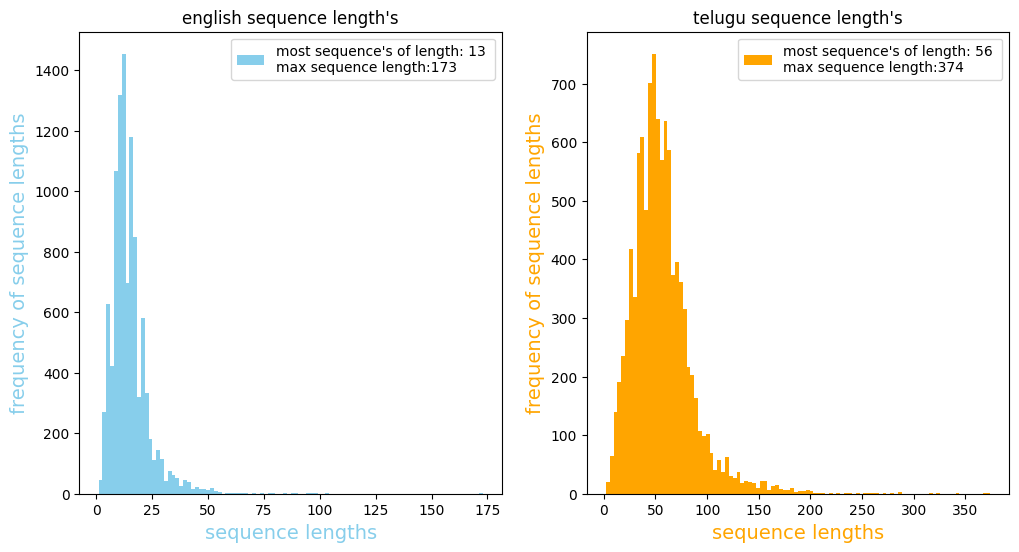

In [3]:
import matplotlib.pyplot as plt

df_c=pd.DataFrame()
df_c["count_e"]=df["english"].apply(lambda x: len(english_vocab.encode(x)))
df_c["count_t"]=df["telugu"].apply(lambda x: len(telugu_vocab.encode(x)))

col_e="skyblue"
col_t="orange"

fig,axis = plt.subplots(1,2,figsize=(12,6))
axis[0].hist(df_c["count_e"], bins=100,color=col_e)
axis[0].set_title("english sequence length's")
axis[0].legend(["most sequence's of length: {s} \nmax sequence length:{s1}".format(s=df_c.mode()["count_e"][0],s1=df_c["count_e"].max())], loc="upper right")
axis[0].set_xlabel("sequence lengths", fontsize=14,c=col_e)
axis[0].set_ylabel("frequency of sequence lengths", fontsize=14,c=col_e)


axis[1].hist(df_c["count_t"], bins=100,color=col_t)
axis[1].set_title("telugu sequence length's")
axis[1].legend(["most sequence's of length: {s} \nmax sequence length:{s1}".format(s=df_c.mode()["count_t"][0],s1=df_c["count_t"].max())], loc="upper right")
axis[1].set_xlabel("sequence lengths", fontsize=14,c=col_t)
axis[1].set_ylabel("frequency of sequence lengths", fontsize=14,c=col_t)
plt.show()

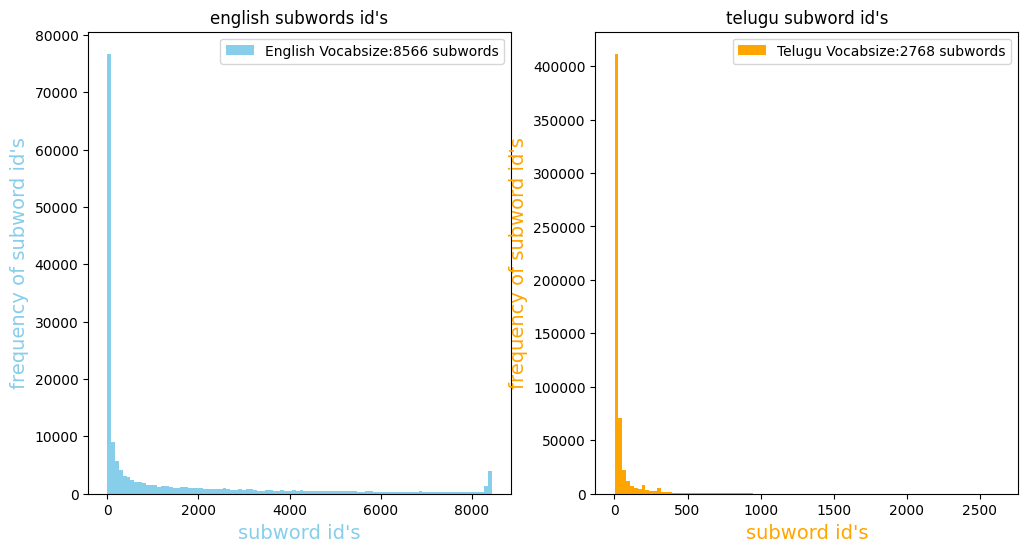

<Figure size 200000x200000 with 0 Axes>

In [4]:
english_corpus=" ".join(df["english"].values.tolist())
english_subwords_ids=english_vocab.encode(english_corpus)

telugu_corpus=" ".join(df["telugu"].values.tolist())
telugu_subwords_ids=telugu_vocab.encode(telugu_corpus)

col_e="skyblue"
col_t="orange"

fig,axis = plt.subplots(1,2,figsize=(12,6))

plt.figure(figsize=(2000,2000))

axis[0].hist(english_subwords_ids, bins=100,color=col_e)
axis[0].set_title("english subwords id's")
axis[0].legend(["English Vocabsize:{s} subwords".format(s=english_vocab.vocab_size)], loc="upper right")
axis[0].set_xlabel("subword id's", fontsize=14,c=col_e)
axis[0].set_ylabel("frequency of subword id's", fontsize=14,c=col_e)

axis[1].hist(telugu_subwords_ids, bins=100,color=col_t)
axis[1].set_title("telugu subword id's")
axis[1].legend(["Telugu Vocabsize:{s} subwords".format(s=telugu_vocab.vocab_size)], loc="upper right")
axis[1].set_xlabel("subword id's", fontsize=14,c=col_t)
axis[1].set_ylabel("frequency of subword id's", fontsize=14,c=col_t)

plt.show()

Text(0, 0.5, 'frequency of subword')

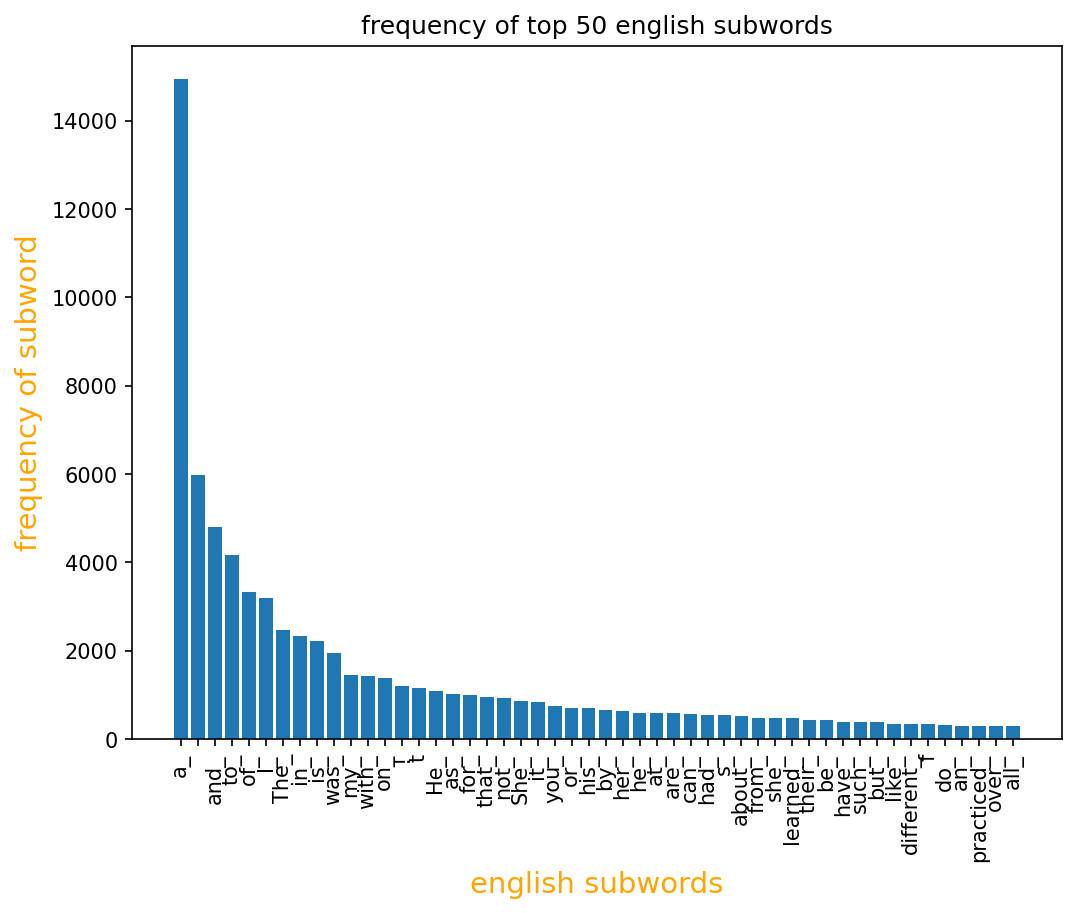

In [5]:
english_subwords=[english_vocab._id_to_subword(i) for i in english_subwords_ids]
df_e=pd.DataFrame(english_subwords,columns=["subword"])
df_eng=pd.DataFrame(df_e["subword"].value_counts(),columns=["count"])

fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.set_title("frequency of top 50 english subwords")
fig.set_dpi(150.0)
plt.xticks(rotation=90)
ax.bar(df_eng[0:50].index,df_eng[0:50]["count"])
ax.set_xlabel('english subwords', fontsize=14,c="orange")
ax.set_ylabel('frequency of subword', fontsize=14,c="orange")

Text(0, 0.5, 'frequency of subword')

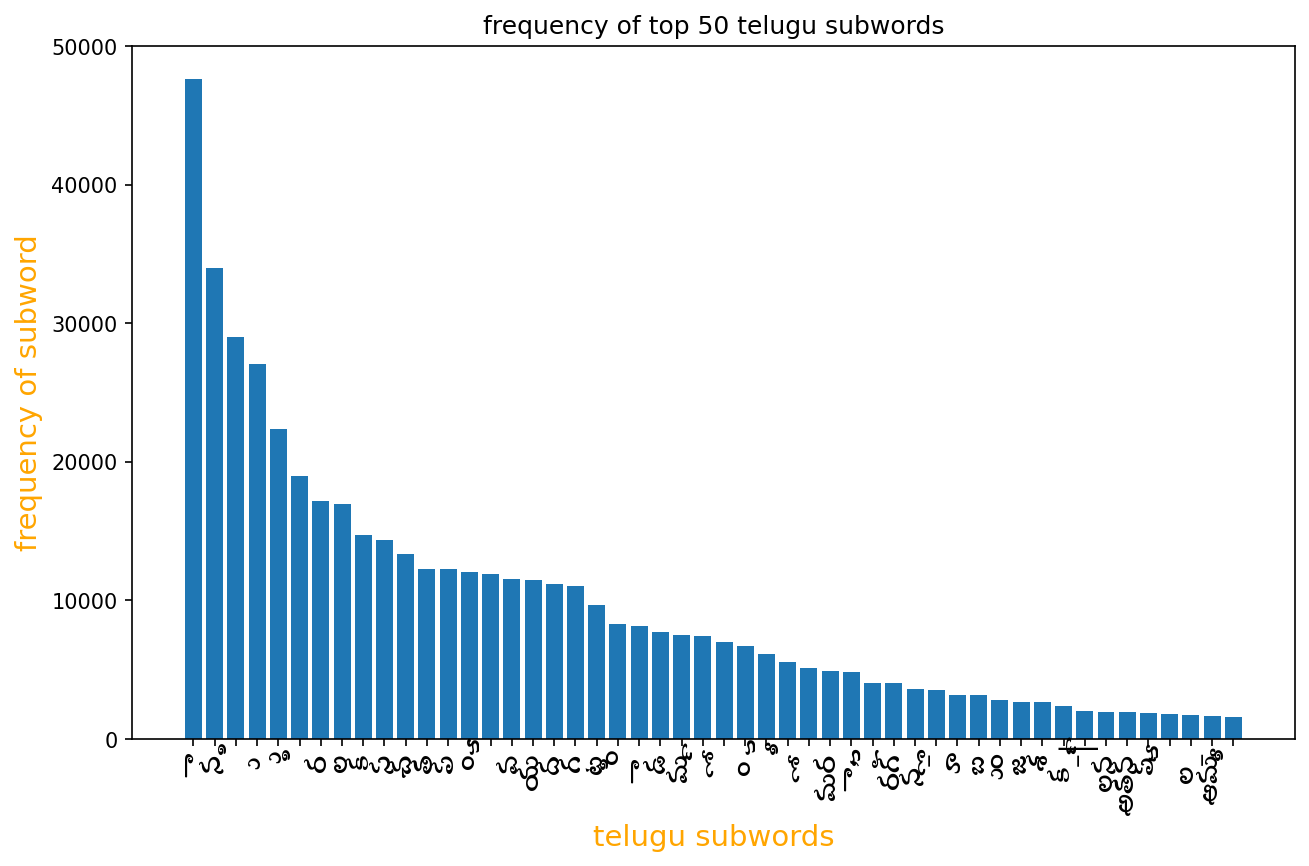

In [6]:
from matplotlib.font_manager import FontProperties


font_prop = FontProperties(fname='/content/Telugu_font.otf')

telugu_subwords=[telugu_vocab._id_to_subword(i) for i in telugu_subwords_ids]
df_t=pd.DataFrame(telugu_subwords,columns=["subword"])
df_tel=pd.DataFrame(df_t["subword"].value_counts(),columns=["count"])
fig,ax=plt.subplots(1,1,figsize=(10,6))
ax.set_title("frequency of top 50 telugu subwords")
plt.xticks(rotation=90)
fig.set_dpi(150.0)

for label in (ax.get_xticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(15)

ax.bar(df_tel[0:50].index,df_tel[0:50]["count"],orientation="vertical")
ax.set_xlabel('telugu subwords', fontsize=14,c="orange")
ax.set_ylabel('frequency of subword', fontsize=14,c="orange")


## Encoding English-Telugu pairs into id's

In [7]:
eng_v=english_vocab.vocab_size
tel_v=telugu_vocab.vocab_size

def encode(e, t):
    eng=[eng_v]+english_vocab.encode(e.numpy())+[eng_v+1]
    tel=[tel_v]+telugu_vocab.encode(t.numpy())+[tel_v+1]
    return eng, tel

def tf_encode(e, t):
    result_e, result_t = tf.py_function(encode, [e, t], [tf.int64, tf.int64])
    result_e.set_shape([None])
    result_t.set_shape([None])
    return result_e, result_t

In [8]:

train, validation = train_test_split(df, test_size=0.05, random_state=20)
train_dataset = tf.data.Dataset.from_tensor_slices(dict(train))
train_dataset = train_dataset.map(lambda x: tf_encode(x['english'], x['telugu']))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(1000).padded_batch(32, padded_shapes=([None],[None]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


# **Transformer Architecture**


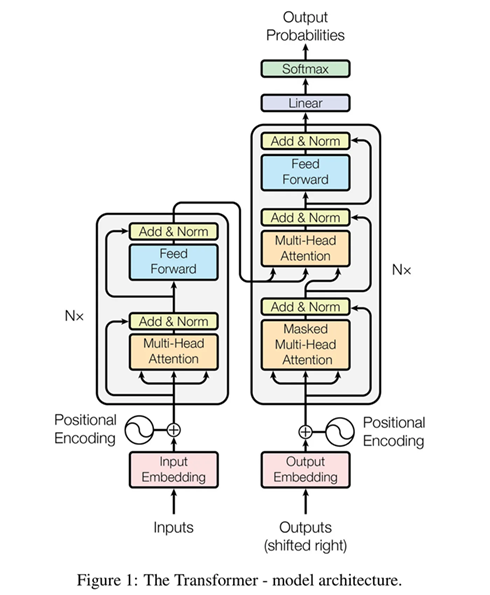

# Positional encoding is computed using the below formula

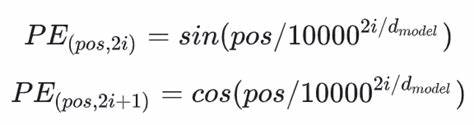

In [9]:

def positional_encoding(d_model,seq_len):

    seq_pos=np.arange(seq_len)[:,np.newaxis] # creating row vector for seq_len
    tok_dm=np.arange(d_model)[np.newaxis,:]  # creating column vector for an token
    tok_dm=1/np.power(10000,2*(tok_dm//2)/np.float32(d_model))
    angle_rads=seq_pos*tok_dm   # angle radians for all tokens in seq_len
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2]) #for even positions using sin()
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2]) #for odd positions using cos()

    pos_encoding=angle_rads[np.newaxis,:]   #adding batch dimension,shape=(1,seq_len,d_model)

    return tf.cast(pos_encoding,dtype=tf.float32)



# **Multihead Attention**


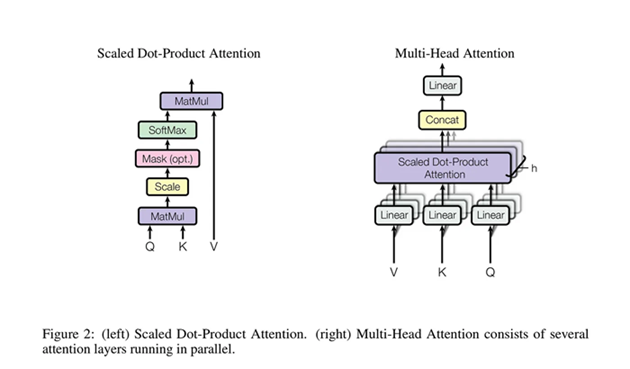


# **Attention matrix is calculated using the following formula**


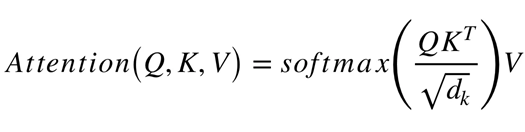

In [10]:
def scaled_dotproduct_attention(q,k,v,mask=None):

    #q,k,v---->(batch_size,heads,seq_len,depth)
    matmul_qk=tf.matmul(q,k,transpose_b=True) #(batch_size,heads,seq_len,seq_len)

    dk=np.sqrt(k.shape[-1])
    scaled_attention_logits=matmul_qk/dk
    if mask is not None:
       scaled_attention_logits += mask*-1e9

    attention_weights=tf.nn.softmax(scaled_attention_logits,axis=-1)
    attention=tf.matmul(attention_weights,v) #(batch_size,heads,seq_len,depth)

    return attention,attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):

       def __init__(self,d_model,no_heads):
           super().__init__()
           
           self.d_model=d_model
           self.no_heads=no_heads
           self.depth=d_model//self.no_heads
           self.wq=tf.keras.layers.Dense(d_model)
           self.wk=tf.keras.layers.Dense(d_model)
           self.wv=tf.keras.layers.Dense(d_model)
           self.wo=tf.keras.layers.Dense(d_model)  #linear activation functions
       def split_heads(self,x):
           batch_size=tf.shape(x)[0]
           x=tf.reshape(x,(batch_size,-1,self.no_heads,self.depth))
           return tf.transpose(x,perm=[0,2,1,3])

       def call(self,q,k,v,mask):
           #q,k,v---->(batch,seq_len,d_model)
           q=self.wq(q)
           k=self.wk(k)
           v=self.wv(v) #q,k,v--->(batch,seq_len,d_model)

           q=self.split_heads(q)
           k=self.split_heads(k)
           v=self.split_heads(v)    #q,k,v--->(batch,no_heads,seq_len,depth)
           attention,attention_weights=scaled_dotproduct_attention(q,k,v,mask)
           # attention.shape=(b,h,s,depth) attention_weights=(b,h,s,s)

           attention=tf.transpose(attention,perm=[0,2,1,3])    #(b,s,h,depth)
           #attention_weights=tf.transpose(attention_weights,perm=[0,2,1,3])
           s=tf.shape(attention)
           concatenate_attention=tf.reshape(attention,(s[0],s[1],s[2]*s[3]))#(b,s,d_model)
           output=self.wo(concatenate_attention)    #(b,s,d_model)
           return output,attention_weights





# **Encoder**

In [11]:
def feed_forward_layer(d_model,dff):
     return tf.keras.Sequential([
         tf.keras.layers.Dense(dff,activation='relu'),
         tf.keras.layers.Dense(d_model)]
     )

class EncodeLayer(tf.keras.layers.Layer):

      def __init__(self,d_model,heads,dff,rate):
          super().__init__()
         
          self.mha = MultiHeadAttention(d_model, heads)
          self.dropout1 = tf.keras.layers.Dropout(rate)
          self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
          self.ffn = feed_forward_layer(d_model, dff)
          self.dropout2 = tf.keras.layers.Dropout(rate)
          self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)



      def call(self,x,training,enc_padding_mask):
          output,_=self.mha(x,x,x,enc_padding_mask)
          output=self.dropout1(output,training=training)
          ffn_input=self.layernorm1(x+output)


          ffn_out=self.ffn(ffn_input)
          ffn_output=self.dropout2(ffn_out,training=training)
          dec_output=self.layernorm2(ffn_input+ffn_output)
          return dec_output



In [12]:
class Encoder(tf.keras.layers.Layer):

      def __init__(self,d_model,max_seqlen,enc_vocab_size,num_layers,heads,dff,rate):
          super().__init__()
        
          self.d_model=d_model
          self.num_layers=num_layers
          self.embedding=tf.keras.layers.Embedding(enc_vocab_size,d_model)
          self.pos_encoding=positional_encoding(d_model,max_seqlen)
          self.encode_layers=[EncodeLayer(d_model,heads,dff,rate) for n in range(self.num_layers)]
          

      def call(self,input,training,enc_padding_mask):
         

          emb_inp=self.embedding(input) #(b,s,d_m)
          emb_inp *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
          seq_l=tf.shape(emb_inp)[1]
          emb_pos=emb_inp+self.pos_encoding[:,:seq_l,:]
          x=emb_pos
          for i in range(self.num_layers):
              x=self.encode_layers[i](x,training,enc_padding_mask)

          return x



# **Decoder**

In [13]:
class Decoderlayer(tf.keras.layers.Layer):

      def __init__(self,d_model,heads,dff,rate):
          super().__init__()
          
          self.mha1=MultiHeadAttention(d_model,heads)
          self.dropout1=tf.keras.layers.Dropout(rate)
          self.lay_norm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)

          self.mha2=MultiHeadAttention(d_model,heads)
          self.dropout2=tf.keras.layers.Dropout(rate)
          self.lay_norm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)

          self.ffn=feed_forward_layer(d_model,dff)
          self.dropout3=tf.keras.layers.Dropout(rate)
          self.lay_norm3=tf.keras.layers.LayerNormalization(epsilon=1e-6)



      def call(self,x,training,enc_out,look_ahead_mask,memory_mask):

          dec_att,_=self.mha1(x,x,x,look_ahead_mask)
          dec_att=self.dropout1(dec_att,training=training)
          q_norm=self.lay_norm1(dec_att+x)

          mha2_out,_=self.mha2(q_norm,enc_out,enc_out,memory_mask)
          mha2_out=self.dropout2(mha2_out,training=training)
          ffn_in=self.lay_norm2(mha2_out+q_norm)

          ffn_out=self.ffn(ffn_in)
          ffn_out=self.dropout3(ffn_out,training=training)
          dec_out=self.lay_norm3(ffn_out+ffn_in)

          return dec_out



In [14]:
class Decoder(tf.keras.layers.Layer):

      def __init__(self,d_model,max_seqlen,dec_vocab_size,num_layers,heads,dff,rate):
          super().__init__()
       
          self.d_model=d_model
          self.num_layers=num_layers
          self.embedding=tf.keras.layers.Embedding(dec_vocab_size,d_model)
          self.pos_enc=positional_encoding(d_model,max_seqlen)
          self.dec_layers=[Decoderlayer(d_model,heads,dff,rate) for n in range(num_layers)]
          self.dropout=tf.keras.layers.Dropout(rate)

      def call(self,input,enc_out,training,look_ahead_mask,memory_mask):

          input=self.embedding(input)
          seq_len=tf.shape(input)[1]
          input+=self.pos_enc[:,:seq_len,:]
          x=input
          for i in range(self.num_layers):
              x=self.dec_layers[i](x,training,enc_out,look_ahead_mask,memory_mask)

          return x


# **Transformer combining Encoder and Decoder**

In [15]:
class Transformer(tf.keras.Model):

      def __init__(self,max_seqlen,d_model,enc_vocab_size,dec_vocab_size,heads,dff,rate,enc_lay,dec_lay):

          super().__init__()
     
          self.enc=Encoder(d_model,max_seqlen,enc_vocab_size,enc_lay,heads,dff,rate)

          self.dec=Decoder(d_model,max_seqlen,dec_vocab_size,dec_lay,heads,dff,rate)

          self.final_layer=tf.keras.layers.Dense(dec_vocab_size)

      def call(self,input,target,training,enc_padding_mask=None,look_ahead_mask=None,memory_mask=None):

          enc_out=self.enc(input,training,enc_padding_mask)

          dec_outout=self.dec(target,enc_out,training,look_ahead_mask,memory_mask)

          word_logits=self.final_layer(dec_outout)


          return word_logits




In [16]:
def padding_mask(seq):  #seq-->(batch_size,seq_len)
    seq=tf.cast(tf.math.equal(seq,0),dtype=float)
    return seq[:,np.newaxis,np.newaxis,:]  #seq-->(batch_size,1,1,seq) for broadcasting

def look_ahead_mask(seq_len):   #seq_len-->length of context window of transformer
    mask=1-tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0) #(seq_len,seq_len)
    return mask


def create_mask(input,target):
    #input,target--->(batchsize,seq_len)
    enc_mask=padding_mask(input)
    dec_mask=enc_mask
    dec_input=padding_mask(target)
    look_ahead=look_ahead_mask(tf.shape(target)[1])
    combined_mask=tf.maximum(dec_input,look_ahead)

    return enc_mask, combined_mask, dec_mask


# **HYPERPARAMETER TUNING**

In [ ]:
# fixed:max_seqlen=512,telugu_vocab_size=2770,english_vocab_size=8568,heads=8
# variable:d_model,dff,rate,enc_lay,dec_lay

class HyperTranslator(keras_tuner.HyperModel):

      def build(self,hp):
          max_seqlen=512
          telugu_vocab_size=telugu_vocab.vocab_size
          english_vocab_size=english_vocab.vocab_size
          heads=8
          d_model=hp.Choice("d_model",[128,256])
          dff=4*d_model
          rate=hp.Float("rate",0.1,0.2,step=0.05)
          enc_lay=hp.Int("enc_lay",2,6,step=2)
          dec_lay=enc_lay
          model=Transformer(max_seqlen,d_model,english_vocab_size,telugu_vocab_size,heads,dff,rate,enc_lay,dec_lay)

          return model

      def fit(self,hp,model,epochs,callbacks=None):

          steps=len(train_dataset)*epochs
          c_d_r=keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001,alpha=0.001,warmup_target=0.002,warmup_steps=0.3*steps,decay_steps=0.7*steps)
          optimizer=keras.optimizers.Adam(c_d_r)
          accuracy=keras.metrics.SparseCategoricalAccuracy()
          loss_mean=keras.metrics.Mean()

          def loss_fn(y_true,y_pred):
              #y_true-->(64,512)
              #y_pred--->(64,512,2768)
              sparse_loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')
              l=sparse_loss(y_true,y_pred)
              loss_weight=tf.cast(tf.math.not_equal(l,0),float)
              l=l*loss_weight
              l=tf.reduce_sum(l)/tf.reduce_sum(loss_weight)
              return l

          train_step_signature = [
          tf.TensorSpec(shape=(None, None), dtype=tf.int64),
          tf.TensorSpec(shape=(None, None), dtype=tf.int64) ]

          @tf.function(input_signature=train_step_signature)
          def train_step(x,y):
              # x,y--->(64,512)
              tar_inp=y[:,:-1]
              tar_out=y[:,1:]

              enc,look_ahead,dec=create_mask(x,tar_inp)

              with tf.GradientTape() as tape:

                    dec_logits=model(x,tar_inp,True,enc,look_ahead,dec)
                    loss=loss_fn(tar_out,dec_logits)
              loss_mean.update_state(loss)
              accuracy.update_state(tar_out,dec_logits)
              gradients=tape.gradient(loss,model.trainable_variables)
              optimizer.apply_gradients(zip(gradients,model.trainable_variables))
          acc=0
          for epoch in range(epochs):
              accuracy.reset_states()
              loss_mean.reset_states()

              for (batch,(x,y)) in enumerate(train_dataset):
                  train_step(x,y)

              acc=max(acc,float(accuracy.result().numpy()))


          return acc


tuner=keras_tuner.RandomSearch(
    hypermodel=HyperTranslator(),
    objective=keras_tuner.Objective(name="default_objective", direction="max"),
    max_trials=6,
    executions_per_trial=2,
    overwrite=True,
    directory="results",
    project_name="translator")

tuner.search(2)


Trial 6 Complete [00h 03m 17s]
default_objective: 0.6100268661975861

Best default_objective So Far: 0.6117937862873077
Total elapsed time: 00h 19m 42s


In [ ]:
tuner.results_summary()

Results summary
Results in results/translator
Showing 10 best trials
Objective(name="default_objective", direction="max")

Trial 3 summary
Hyperparameters:
d_model: 128
rate: 0.15000000000000002
enc_lay: 6
Score: 0.6117937862873077

Trial 1 summary
Hyperparameters:
d_model: 256
rate: 0.2
enc_lay: 6
Score: 0.6116739809513092

Trial 4 summary
Hyperparameters:
d_model: 128
rate: 0.2
enc_lay: 2
Score: 0.6105193197727203

Trial 5 summary
Hyperparameters:
d_model: 128
rate: 0.1
enc_lay: 4
Score: 0.6100268661975861

Trial 2 summary
Hyperparameters:
d_model: 128
rate: 0.1
enc_lay: 2
Score: 0.6098251938819885

Trial 0 summary
Hyperparameters:
d_model: 256
rate: 0.15000000000000002
enc_lay: 2
Score: 0.6096941530704498


Here is a table summarizing all the trials, sorted by score:

| Trial | d_model | rate | enc_lay | Score         |
|-------|---------|------|---------|---------------|
| 3     | 128     | 0.15 | 6       | 0.6117937863  |
| 1     | 256     | 0.2  | 6       | 0.6116739810  |
| 4     | 128     | 0.2  | 2       | 0.6105193198  |
| 5     | 128     | 0.1  | 4       | 0.6100268662  |
| 2     | 128     | 0.1  | 2       | 0.6098251939  |
| 0     | 256     | 0.15 | 2       | 0.6096941531  |

**Trail 2 has almost same accuracy(0.6098) even with 2 layers than with Trail 3 of 6 layers**

**Therefore choosing trail 2 for further training with more number of epochs**


In [49]:
history={"loss":[],"accuracy":[]}
def fit(model,epochs):

    steps=len(train_dataset)*epochs
    cosine_decay_rate=keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001,alpha=0.001,warmup_target=0.002,warmup_steps=0.3*steps,decay_steps=0.7*steps)
    optimizer=keras.optimizers.Adam(cosine_decay_rate)
    accuracy=keras.metrics.SparseCategoricalAccuracy()
    loss_mean=keras.metrics.Mean()

    def loss_fn(y_true,y_pred):
        #y_true-->(64,512)
        #y_pred--->(64,512,2768)

        sparse_loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')
        l=sparse_loss(y_true,y_pred)
        loss_weight=tf.cast(tf.math.not_equal(y_true,0),float)
        l=l*loss_weight
        l=tf.reduce_sum(l)/tf.reduce_sum(loss_weight)
        return l

    def accuracy_fn(y_true,y_pred):

        acc_weight=tf.cast(tf.math.not_equal(y_true,0),tf.int64)
        accuracy.update_state(y_true,y_pred,sample_weight=acc_weight)

    train_step_signature = [tf.TensorSpec(shape=(None, None), dtype=tf.int64),tf.TensorSpec(shape=(None, None), dtype=tf.int64)]

    @tf.function(input_signature=train_step_signature)
    def train_step(x,y):
        # x,y--->(64,512)
        tar_inp=y[:,:-1]
        tar_out=y[:,1:]

        enc,look_ahead,dec=create_mask(x,tar_inp)

        with tf.GradientTape() as tape:

              dec_logits=model(x,tar_inp,True,enc,look_ahead,dec)
              loss=loss_fn(tar_out,dec_logits)
        accuracy_fn(tar_out,dec_logits)

        loss_mean.update_state(loss)
        gradients=tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(gradients,model.trainable_variables))

    for epoch in range(epochs):
         accuracy.reset_states()
         loss_mean.reset_states()
         print("\nepoch {}/{}".format(epoch+1,epochs))
         pb_i = Progbar(train.shape[0],stateful_metrics=["loss","accuracy"])
         for (batch,(x,y)) in enumerate(train_dataset):
             train_step(x,y)
             history["loss"].append(loss_mean.result())
             history["accuracy"].append(accuracy.result())

             values=[('loss',loss_mean.result()),("accuracy",accuracy.result())]
             pb_i.add(32, values=values)


In [50]:
#WITH TRAIL 2 HYPERPARAMETERS
#telugu_vocab_size=2768
#english_vocab_size=8566

max_seqlen=512
d_model=128
telugu_vocab_size=2770
english_vocab_size=8568
heads=8
dff=4*d_model
rate=0.1
enc_lay=2
dec_lay=2

translator=Transformer(max_seqlen,d_model,english_vocab_size,telugu_vocab_size,heads,dff,rate,enc_lay,dec_lay)


In [51]:
fit(translator,60)


epoch 1/60
9696/9694 [==============================] - 51s 5ms/step - loss: 4.0784 - accuracy: 0.1332

epoch 2/60
9696/9694 [==============================] - 17s 2ms/step - loss: 2.8461 - accuracy: 0.3142

epoch 3/60
9696/9694 [==============================] - 16s 2ms/step - loss: 2.2949 - accuracy: 0.4346

epoch 4/60
9696/9694 [==============================] - 15s 2ms/step - loss: 1.9016 - accuracy: 0.5170

epoch 5/60
9696/9694 [==============================] - 15s 2ms/step - loss: 1.6157 - accuracy: 0.5810

epoch 6/60
9696/9694 [==============================] - 15s 2ms/step - loss: 1.3799 - accuracy: 0.6364

epoch 7/60
9696/9694 [==============================] - 15s 2ms/step - loss: 1.1819 - accuracy: 0.6860

epoch 8/60
9696/9694 [==============================] - 15s 2ms/step - loss: 1.0136 - accuracy: 0.7276

epoch 9/60
9696/9694 [==============================] - 15s 2ms/step - loss: 0.8847 - accuracy: 0.7591

epoch 10/60
9696/9694 [==============================] - 15s 2m

In [52]:
translator.summary() #2.73 million paramerters

Model: "transformer_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  1493248   
                                                                 
 decoder_5 (Decoder)         multiple                  883712    
                                                                 
 dense_357 (Dense)           multiple                  357330    
                                                                 
Total params: 2734290 (10.43 MB)
Trainable params: 2734290 (10.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


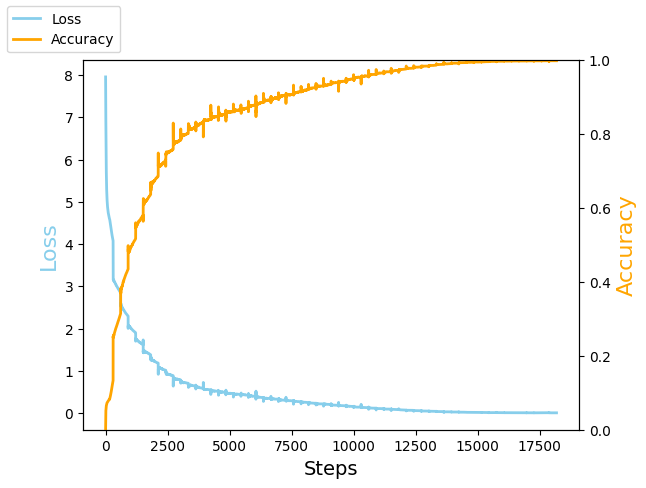

In [53]:
import matplotlib.pyplot as plt

col_l="skyblue"
col_a="orange"

fig,ax = plt.subplots()
ax.plot(range(len(history["loss"])), history["loss"], color=col_l ,linewidth=2)
ax.set_xlabel('Steps', fontsize=14)
ax.set_ylabel('Loss', color=col_l, fontsize=16)
ax2 = ax.twinx()
ax2.plot(range(len(history["loss"])), history["accuracy"], color=col_a, linewidth=2)
ax2.set_ylim(0,1)
ax2.set_ylabel('Accuracy', color=col_a, fontsize=16)
fig.legend(["Loss","Accuracy"], loc="upper left")
plt.show()

In [64]:
#tel_vocab=2768
#eng_vocab=8566

def translate(input):

    telugu_vocab_size=telugu_vocab.vocab_size
    english_vocab_size=english_vocab.vocab_size

    input_sen=[english_vocab_size]+english_vocab.encode(input)+[english_vocab_size+1]
    input_sen=tf.expand_dims(input_sen,0)
    dec_inp=[telugu_vocab_size]
    dec_inp=tf.expand_dims(dec_inp,0)

    for i in range(200):

         enc,com,dec=create_mask(input_sen,dec_inp)
         logits=translator(input_sen,dec_inp,False,enc,com,dec)
         prob_words=logits[:,-1:,:]
         pred_words=tf.cast(tf.argmax(prob_words,axis=-1),tf.int32)
         pred_wordid=pred_words
         if(pred_wordid==telugu_vocab_size+1):
            #print("end token")
            break

         dec_inp=tf.concat([dec_inp,pred_wordid],axis=-1)

    dec_inp=tf.squeeze(dec_inp,axis=0)
    dec_string=telugu_vocab.decode([ i for i in dec_inp if i <telugu_vocab_size])

    return dec_string


In [71]:
translator.save_weights("/content/model_weights")

# **BLEU Evaluation on Validation Dataset**

In [60]:
def bleu_evaluation(test_df):
    test_df["predictions"]=test_df["english"].apply(lambda x:translate(x))
    bleu=evaluate.load("bleu")
    result=bleu.compute(predictions=test_df["predictions"].values.tolist(),references=test_df["telugu"].values.tolist())
    return result


In [66]:
val_df=validation.sample(100)
bleu_evaluation(val_df)

{'bleu': 0.43872043710226205,
 'precisions': [0.5927552140504939,
  0.45129469790382243,
  0.40870786516853935,
  0.38825448613376834],
 'brevity_penalty': 0.9665439190167537,
 'length_ratio': 0.9670912951167728,
 'translation_length': 911,
 'reference_length': 942}

# prediction validation samples

In [69]:
val_df.sample(10)

,english,telugu,predictions
8905,The shooter says goodbye to his love,షూటర్ తన ప్రేమకు వీడ్కోలు పలికారు,షూటర్ తన ప్రేమకు వీడ్కోలు పలికారు
1841,He cannot play the guitar,అతను గిటార్ ప్లే చేయలేడు,అతను గిటార్ వాయించడం నేను గిట్లాడు
7388,The elderly neighborhood became enraged over t...,పూడ్లే అదృశ్యానికి కారణమైన కొయెట్లపై వృద్ధ పొర...,పూడ్లే అదృశ్యానికి కారణమైన కొయెట్లపై వృద్ధ పొర...
8864,I can not believe this is the eighth time I am...,నేను అదే రోజున నా పిగ్గీ బ్యాంకును తెరిచిన ఎని...,నేను అదే రోజున నా పిగ్గీ బ్యాంకును తెరిచిన ఎని...
707,Deep learning algorithms discover multiple le...,లోతైన అభ్యాస అల్గోరిథంలు బహుళ స్థాయి ప్రాతిని...,దీని అడవి వంతో ఎక్కువ షోర్థానిక లక్షణాలు ప్రవ...
3853,He felt the thrill of adrenaline as he rode a ...,అతను రోలర్ కోస్టర్‌ను నడిపినప్పుడు ఆడ్రినలిన్ ...,అతను రోలర్ కోస్టర్ నడిపోతున్నప్పుడు అతను తన భయ...
9377,He was not bitter that she had moved on but fr...,"అతను చేదుగా లేడు, ఆమె ముందుకు సాగింది కాని ముల...","అతను చేదుగా లేడు, ఆమె ముందుకు సాగింది కాని ముల..."
9359,Pink horses galloped across the sea,పింక్ గుర్రాలు సముద్రం మీదుగా పరుగెత్తాయి,పింక్ గుర్రాలు సముద్రం మీదుగా పరుగెత్తాయి
1673,She is attending a concert of her favorite band,ఆమె తన అభిమాన బృందం కచేరీకి హాజరవుతోంది,ఆమె తన అభిమాన బృందం కచేరీకి హాజరవుతోంది
6905,The fox in the tophat whispered into the ear o...,తోఫాట్‌లోని నక్క కుందేలు చెవిలోకి గుసగుసలాడుతో...,తోఫాట్‌లోని నక్క కుందేలు చెవిలోకి గుసగుసలాడుతో...


# let's test some random validation sample's

In [104]:
def validation_sample():
    sample=validation.sample(1).values
    print("English-Telugu pair")
    print(sample[0][0])
    print(sample[0][1])
    print("   ")
    print("PREDICTED TELUGU SENTENCE:")
    print(translate(sample[0][0]))

In [105]:
validation_sample()

English-Telugu pair
I like this game
నాకు ఈ ఆట ఇష్టం
   
PREDICTED TELUGU SENTENCE:
నేను ఆట ఆడదాము


In [106]:
validation_sample()

English-Telugu pair
We are going on a family vacation next week 
మేము వచ్చే వారం కుటుంబ సెలవులకు వెళ్తున్నాము 
   
PREDICTED TELUGU SENTENCE:
మేము వచ్చే వారం ఒక కుటుంబం పెప్రయోతున్నాము 


In [108]:
validation_sample()

English-Telugu pair
A central application of unsupervised learning is in the field of density estimation in statistics  such as finding the probability density function 
పర్యవేక్షించబడని అభ్యాసం యొక్క కేంద్ర అనువర్తనం గణాంకాలలో సాంద్రత అంచనా రంగంలో ఉంది, సంభావ్యత సాంద్రత పనితీరును కనుగొనడం వంటివి 
   
PREDICTED TELUGU SENTENCE:
పర్యవేక్షించబడుతుంది, ఉపబల అభ్యాస అనేక శక్తిపరమైన దృశ్యం సంభాయంలో శిలుస్తుంది, ఇది సంభావ్యత సంస్వభావం యొక్క శక్తిగా ఉంటుంది 


In [113]:
validation_sample()

English-Telugu pair
He always orders the same thing at the restaurant 
అతను ఎల్లప్పుడూ రెస్టారెంట్‌లో అదే విషయాన్ని ఆదేశిస్తాడు 
   
PREDICTED TELUGU SENTENCE:
అతను నేతన వీలుగా ఒక స్పార్క్ ఇచ్చాడు 


In [114]:
validation_sample()

English-Telugu pair
He felt a sense of accomplishment as he was painting in the contest
అతను పోటీలో పెయింటింగ్ చేస్తున్నందున అతను సాఫల్య భావనను అనుభవించాడు
   
PREDICTED TELUGU SENTENCE:
అతను ఇంటిప్‌లో సాధన చేయడంత్రాడుతో అతను సాధన ఉపయోగించండి 


In [115]:
validation_sample()

English-Telugu pair
The secret code they created made no sense  even to them 
వారు సృష్టించిన రహస్య కోడ్ వారికి కూడా అర్ధమే లేదు 
   
PREDICTED TELUGU SENTENCE:
వారు సృష్టించిన రహస్య కోడ్ వారికి కూడా అర్ధమే లేదు 


In [116]:
validation_sample()

English-Telugu pair
I learned to do a puzzle and completed a challenging one with lots of pieces 
నేను ఒక పజిల్ చేయడం నేర్చుకున్నాను మరియు చాలా ముక్కలతో సవాలు చేసేదాన్ని పూర్తి చేసాను 
   
PREDICTED TELUGU SENTENCE:
నేను సవాలు చేయడం నేర్చుకున్నాను మరియు చాలా మూల్ చేయడం నేర్చుకున్నాను 


In [117]:
validation_sample()

English-Telugu pair
Her life in the confines of the house became her new normal 
ఇంటి పరిమితుల్లో ఆమె జీవితం ఆమె కొత్త సాధారణమైంది 
   
PREDICTED TELUGU SENTENCE:
ఇంటి పరిమితుల్లో ఆమె జీవితం ఆమె కొత్త సాధారణమైంది 


## THE END